# Predicting Diabetes

This dataset originally comes from the National Institute of Diabetes and Digestive and Kidney Diseases. The goal is to predict, based on diagnostic measures, whether or not a patient has diabetes

In [1]:
import logging 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.tree import plot_tree
from sklearn.model_selection import ( train_test_split, GridSearchCV ) 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import ( MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder ) 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ( 
        accuracy_score, 
        f1_score, 
        matthews_corrcoef, 
        classification_report, 
        ConfusionMatrixDisplay ) 
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
import pickle
logger = logging.getLogger()
logger.setLevel(logging.INFO)


### **1. Data loading** **Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv
url = ('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')
df_raw = pd.read_csv(url, sep=',')

# Mostrar las primeras filas del dataset para revisión
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### **2. Data Preprocesing**
**Objective**: Perform the data cleaning, data information and data reduction steps to avoid data mistmatching, noisy data

In [3]:
df_baking = df_raw.copy()


In [4]:
df_baking.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
df_baking.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
df_baking['Outcome'].value_counts(normalize=True)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

In [4]:
# Verificación de ceros en variables donde no deberían existir
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_baking[zero_columns].isin([0]).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [5]:
# Reemplazar ceros por NaN en las columnas donde no deberían existir ceros
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_baking[columns_to_replace] = df_baking[columns_to_replace].replace(0, np.nan)

# Verificación de cuántos valores nulos hay ahora
df_baking.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [6]:
# Imputar valores nulos en 'Glucose', 'BloodPressure' y 'BMI' con la mediana de cada columna
columns_to_impute = ['Glucose', 'BloodPressure', 'BMI']
for col in columns_to_impute:
    median_value = df_baking[col].median()
    df_baking[col] = df_baking[col].fillna(median_value)

In [7]:
# Eliminar las columnas 'SkinThickness' e 'Insulin'
df_baking.drop(columns=['SkinThickness', 'Insulin'], inplace=True)

In [8]:
# Verificación final: revisar si todavía quedan nulos
df_baking.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
df=df_baking.copy()

In [10]:
# Separar variables predictoras (X) y la variable objetivo (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Realizar la división train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% para test
    random_state=42,    # para reproducibilidad
    stratify=y          # para mantener la proporción de clases
)

# Mostrar las dimensiones de los splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 6), (154, 6), (614,), (154,))

In [11]:
# Unificar los conjuntos de entrenamiento y prueba
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [12]:
# Mostrar la forma de los conjuntos de entrenamiento y prueba
train_df.shape, test_df.shape

((614, 7), (154, 7))

In [17]:
# Mostrar las primeras filas del conjunto de entrenamiento
train_df.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
353,1,90.0,62.0,27.2,0.580,24,0
711,5,126.0,78.0,29.6,0.439,40,0
373,2,105.0,58.0,34.9,0.225,25,0
46,1,146.0,56.0,29.7,0.564,29,0
682,0,95.0,64.0,44.6,0.366,22,0


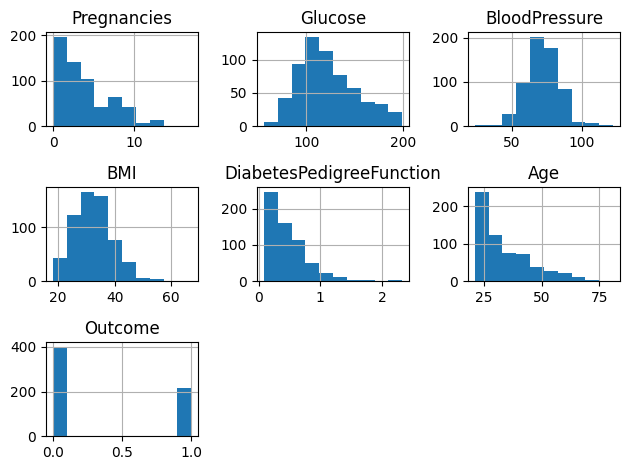

In [13]:
#Análisis Univariado
train_df.hist()
plt.tight_layout()
plt.show()

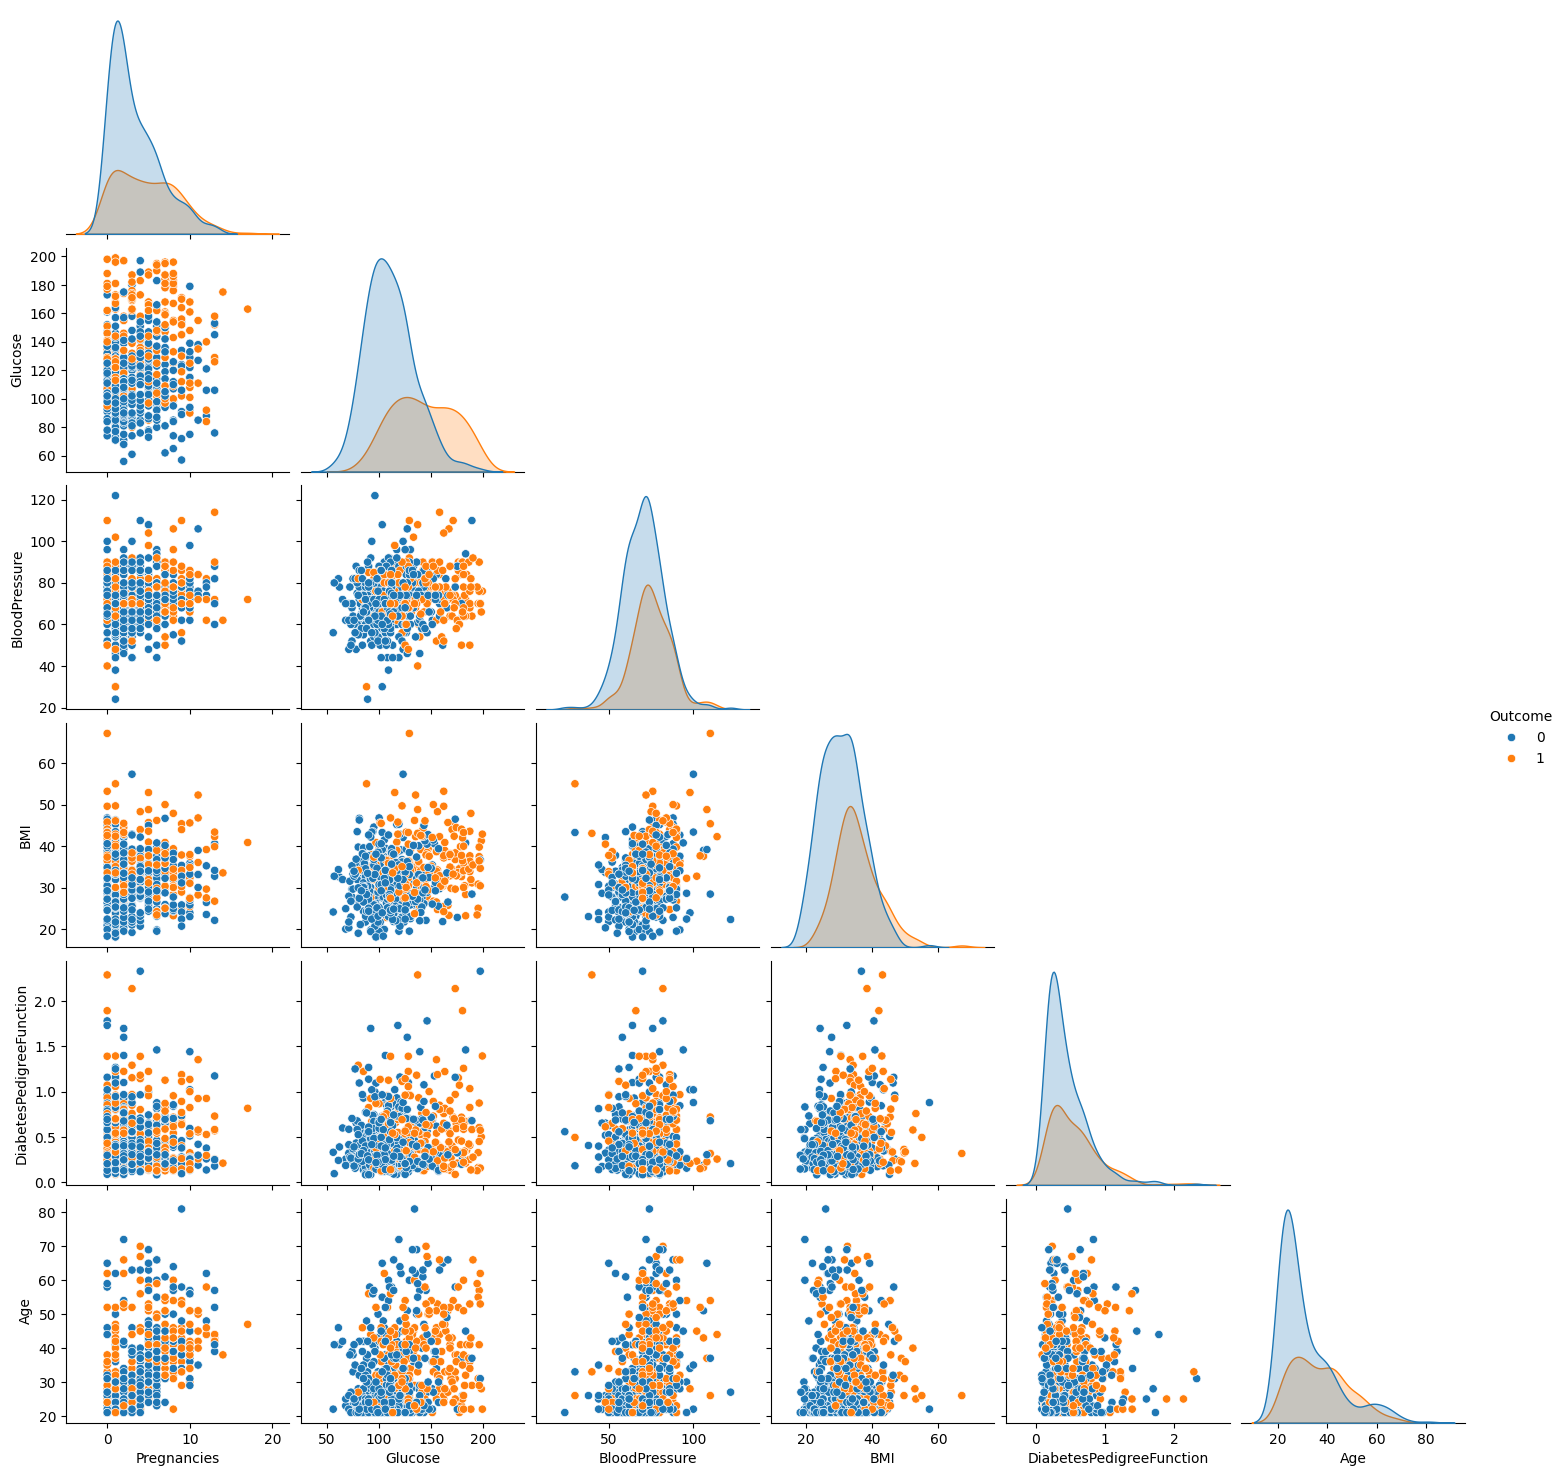

In [14]:
# análisis bivariado
sns.pairplot(train_df,hue = "Outcome", corner=True)
plt.show()


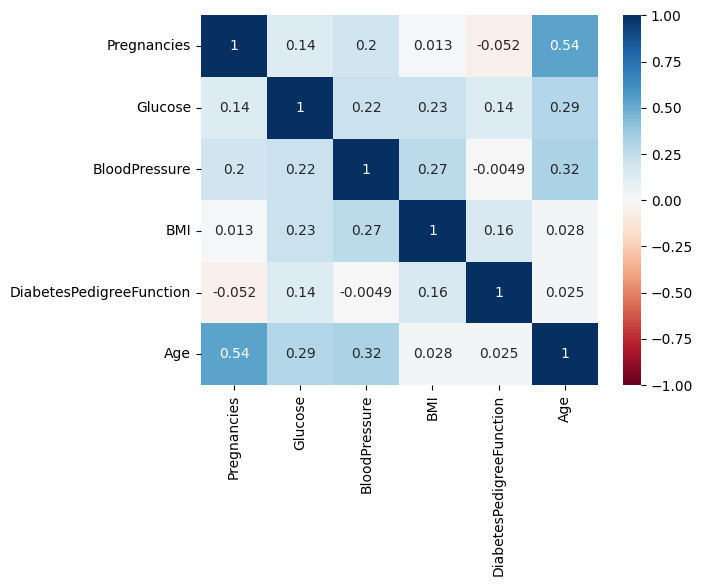

In [15]:
#Correlación
sns.heatmap(
    train_df.drop(columns=['Outcome']).corr(), 
    vmin=-1, vmax=1, annot=True, cmap='RdBu'
)
plt.show()


### **4. Machine learning** 
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [16]:
# Dividir el dataset en conjunto de entrenamiento y prueba
X_train = train_df.drop('Outcome', axis=1)
y_train = train_df['Outcome']
X_test = test_df.drop('Outcome', axis=1)
y_test = test_df['Outcome']

# Mostrar las dimensiones de los conjuntos de entrenamiento y prueba
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 6), (154, 6), (614,), (154,))

In [19]:
# Mostrar las primeras filas del conjunto de entrenamiento
X_train.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
353,1,90.0,62.0,27.2,0.580,24
711,5,126.0,78.0,29.6,0.439,40
373,2,105.0,58.0,34.9,0.225,25
46,1,146.0,56.0,29.7,0.564,29
682,0,95.0,64.0,44.6,0.366,22


In [20]:
# Mostrar las primeras filas del conjunto de entrenamiento
y_train.head()

353    0
711    0
373    0
46     0
682    0
Name: Outcome, dtype: int64

In [17]:
# Entrenar el primer modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [18]:
# Realizar predicciones en el conjunto de prueba
y_pred = tree_model.predict(X_test)
y_pred_proba = tree_model.predict_proba(X_test)[:, 1]  # Probabilidades para calcular AUC

In [19]:
# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Mostrar resultados

print(" Resultados del Modelo")
print("------------------------------")
print(f" Accuracy: {round(accuracy, 4)}")
print(f" Recall:   {round(recall, 4)}")
print(f" F1 Score: {round(f1, 4)}")
print(f" AUC:      {round(auc, 4)}")
print("------------------------------")

 Resultados del Modelo
------------------------------
 Accuracy: 0.6883
 Recall:   0.5
 F1 Score: 0.5294
 AUC:      0.645
------------------------------


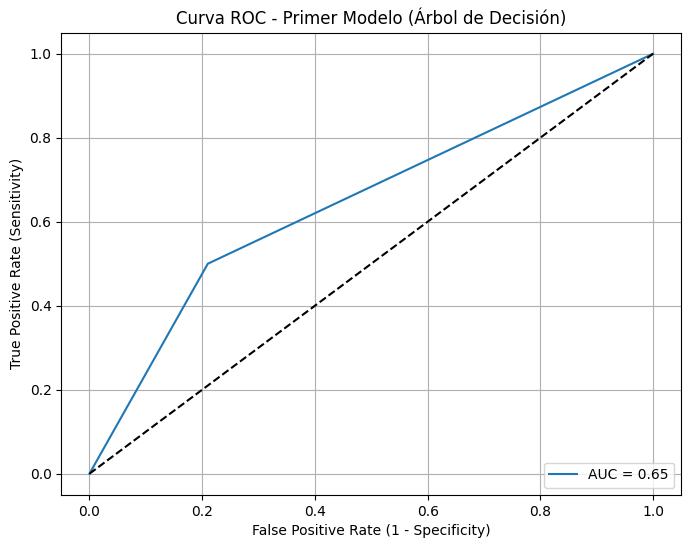

In [20]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Curva ROC - Primer Modelo (Árbol de Decisión)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

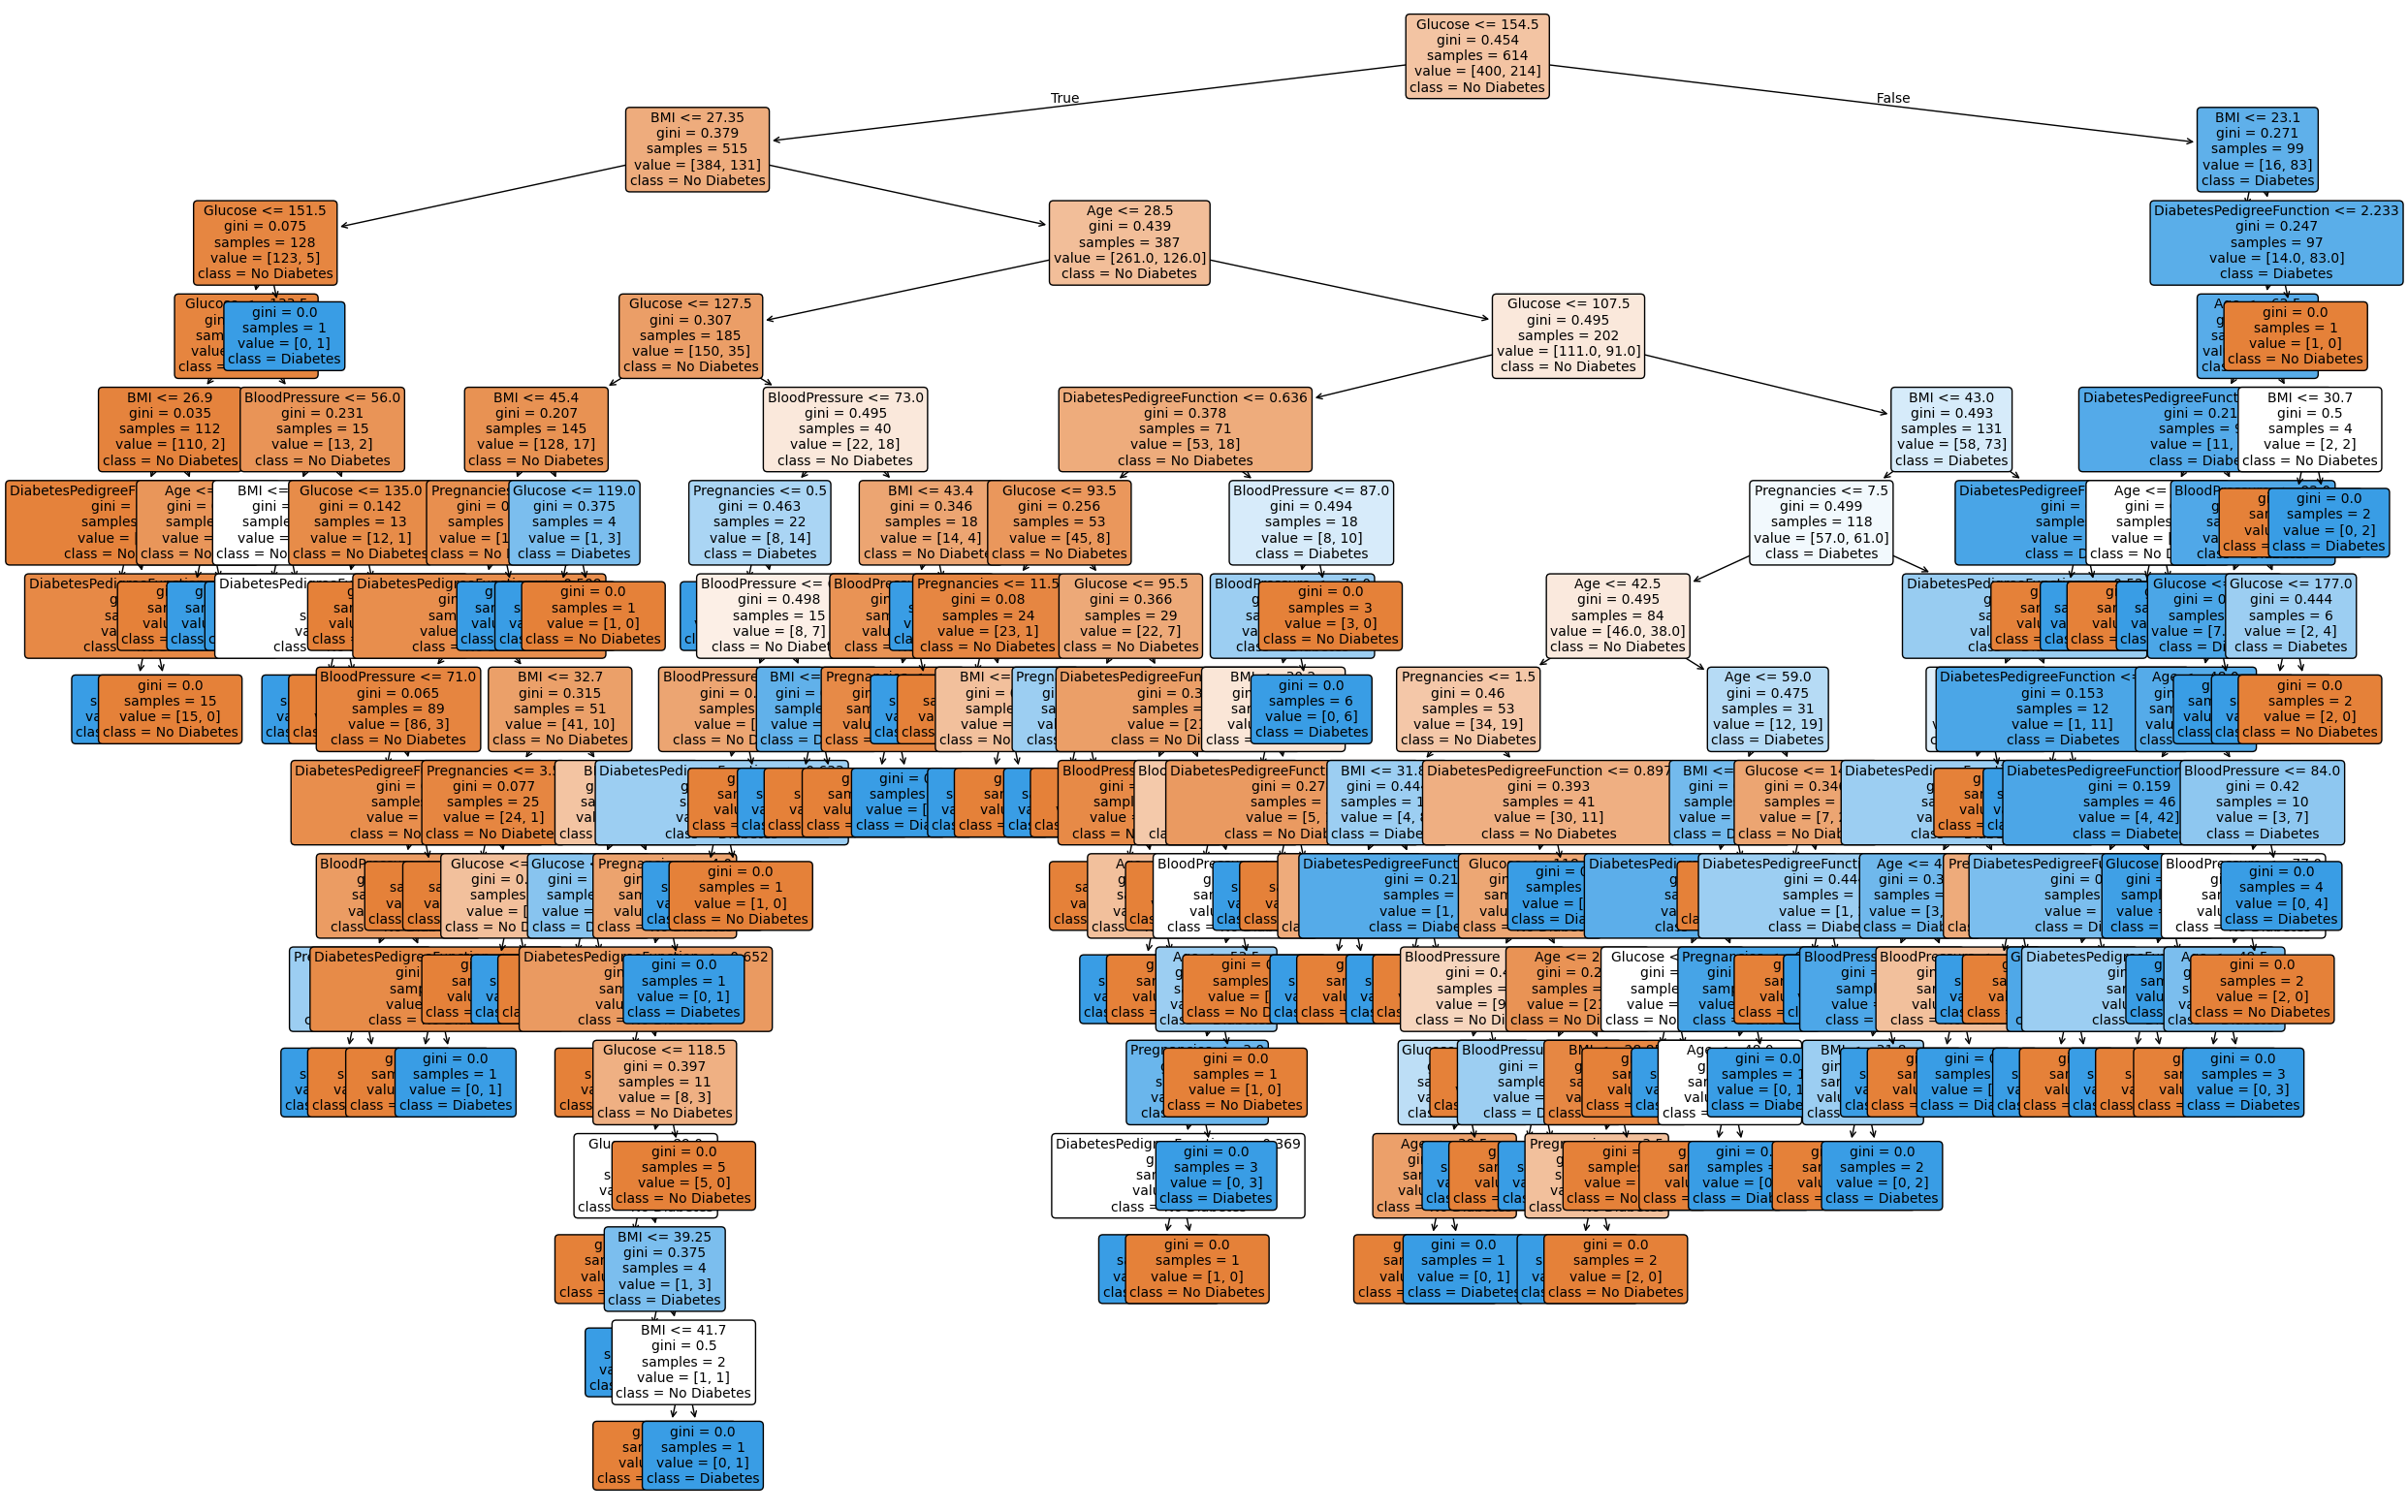

In [25]:
# Definir tamaño de la figura
plt.figure(figsize=(30,20))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          feature_names=X_train.columns, 
          class_names=["No Diabetes", "Diabetes"], 
          filled=True, 
          rounded=True, 
          fontsize=10)

# Mostrar el gráfico
plt.show()

In [21]:
# Definir modelo base
tree_base = DecisionTreeClassifier(random_state=42)

# Definir un grid de hiperparámetros un poco más amplio y balanceado
param_grid = {
    'max_depth': [3, 5, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy']
}

# Definir GridSearchCV usando AUC como métrica de evaluación
grid_search = GridSearchCV(
    estimator=tree_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,  # utilizar todos los núcleos disponibles
    verbose=1
)

# Ajustar el GridSearch al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8, 10, 12],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='roc_auc', verbose=1)

In [27]:
# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 20}


In [22]:
# Entrenar el modelo final con los mejores hiperparámetros encontrados
tree_best = grid_search.best_estimator_
tree_best.fit(X_train, y_train)

# Predicciones
y_pred_best = tree_best.predict(X_test)
y_pred_proba_best = tree_best.predict_proba(X_test)[:, 1]

# Calcular métricas
accuracy_best = accuracy_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_pred_proba_best)

# Mostrar resultados
print(" Resultados del Modelo Ajustado")
print("------------------------------")
print(f" Accuracy: {round(accuracy_best, 4)}")
print(f" Recall:   {round(recall_best, 4)}")
print(f" F1 Score: {round(f1_best, 4)}")
print(f" AUC:      {round(auc_best, 4)}")
print("------------------------------")

 Resultados del Modelo Ajustado
------------------------------
 Accuracy: 0.6948
 Recall:   0.2778
 F1 Score: 0.3896
 AUC:      0.7708
------------------------------


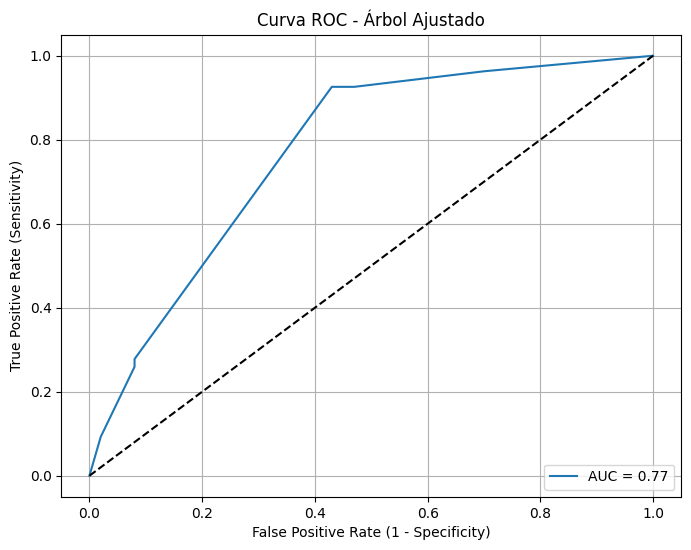

In [29]:
# Visualizar la Curva ROC
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(8,6))
plt.plot(fpr_best, tpr_best, label=f'AUC = {auc_best:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Curva ROC - Árbol Ajustado')
plt.legend(loc='lower right')
plt.grid()
plt.show()

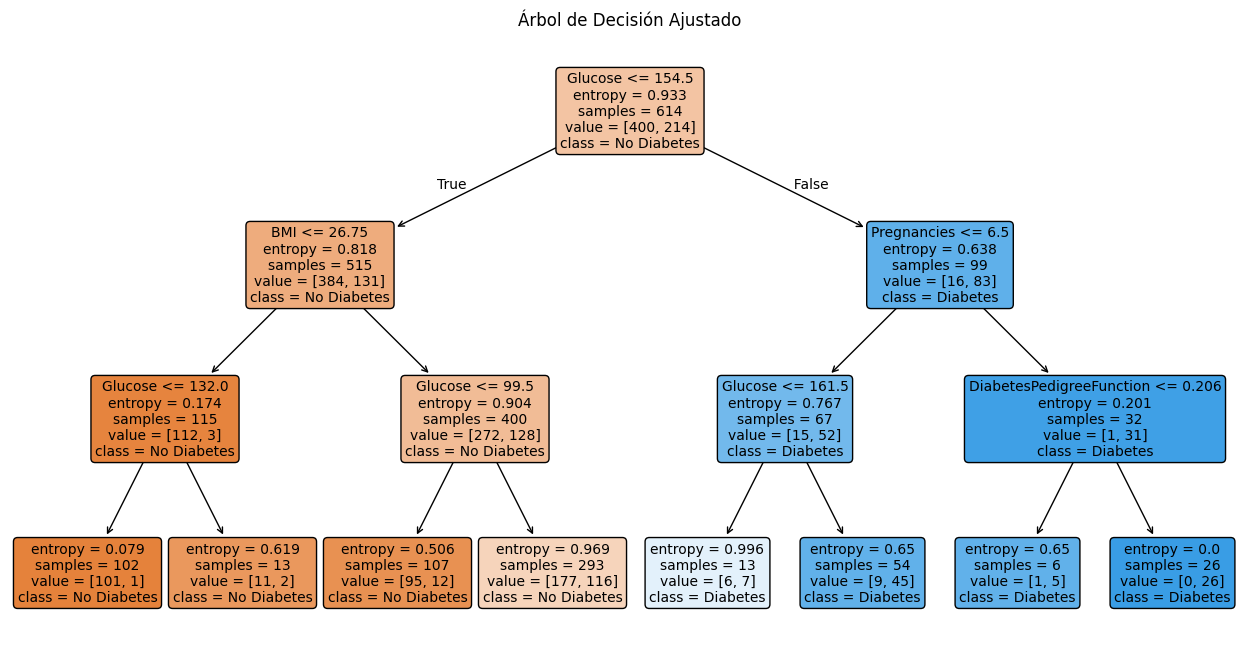

In [30]:
# Visualizar el árbol
plt.figure(figsize=(16,8))
plot_tree(tree_best, 
          feature_names=X_train.columns, 
          class_names=["No Diabetes", "Diabetes"], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title('Árbol de Decisión Ajustado')
plt.show()

### **5. Model saving**
### **Objective**: Save the model and some critical information we consider necessary


In [ ]:
model_dict = {
    'model': tree_best,  
    'predictors': X_train.columns.to_list(),
    'target_name': 'Outcome',  # Corregido el nombre de la clave
    'target_classes_proba': tree_best.predict_proba, # Guardando la función para obtener probabilidades
    'metrics': {'accuracy': 0.6883, 'f1': 0.5294}, # Guardando métricas como diccionario
    'Author': 'Kleineer Tabata'    
}


In [24]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model_dict, file)